<a href="https://colab.research.google.com/github/sammdog/logBB_prediction/blob/main/_%D0%B3%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%BE%D1%82%D0%B1%D0%BE%D1%80_%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%B2_%2B_linear_%2B_knn%2Bforest%2Bansamble%2Blgbmgradient%2Bnnregr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Генерация и отбор признаков**

In [ ]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 1.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np

from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Crippen, Descriptors, GraphDescriptors, Lipinski, QED, rdMolDescriptors
from tqdm import tqdm

In [ ]:
sdf = pd.read_csv('regression_1711_cleaned.csv')
sdf.rename(columns={'SMILES_uncharge': 'SMILES'}, inplace=True)
#df = pd.read_csv('Class_labels (1).csv')
#df.rename(columns={'SMILES_uncharge': 'SMILES'}, inplace=True)
#sdf['class']=df['Class']
#df=sdf.drop('logBB',axis=1)
pd.set_option('display.max_rows', None)
df = sdf.sort_values('logBB')
df.tail(10)#['SMILES']

,logBB,SMILES,#HBA,#ROTB,#ALERTS,MlogP,#MR,#NHOH,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,Morgan3,MaxPartialCharge,MinPartialCharge,BalabanJ,Ipc,HallKierAlpha,Kappa3
176,1.19,CN(C)CCCN1C2=CC=CC=C2SC2=CC=CC=C21,3.0,4.0,0.0,4.24,87.18,0.0,2.0,0.0,3.0,2.00,0.06,-0.34,1.91,51348.90,-1.45,2.69
458,1.20,CCC1=CC=CC(N=C(C)NC2=CC=CC(CC)=C2)=C1,1.0,4.0,2.0,4.97,88.03,1.0,2.0,0.0,2.0,2.30,0.10,-0.34,2.13,38082.35,-2.09,3.95
518,1.25,OC1=CC=C2C(OC3=CC=C(OCCN4CCCCC4)C=C3)=C(C3=CC=...,4.0,7.0,0.0,7.01,133.31,1.0,4.0,0.0,5.0,2.29,0.14,-0.51,1.36,81471223.14,-3.57,5.15
146,1.25,CN(C)CCOC(C1=CC=CC=C1)C1=CC=CC=C1,2.0,6.0,0.0,3.35,79.23,0.0,2.0,0.0,2.0,1.74,0.11,-0.37,2.14,26276.55,-1.64,4.19
363,1.25,CC(NC(C)(C)C)C(=O)C1=CC=CC(Cl)=C1,2.0,3.0,1.0,3.30,68.13,1.0,1.0,0.0,3.0,2.50,0.18,-0.30,2.78,2302.60,-0.86,3.95
406,1.26,COC1=CC=C(C2=NN(C)C(C3=CC=CC(CN(C)C)=C3)=N2)C=C1,4.0,5.0,0.0,3.22,95.82,0.0,2.0,1.0,5.0,2.46,0.18,-0.50,1.93,363326.24,-2.66,3.46
598,1.26,CN(C)COC(C1=CC=CC=C1)C1=CC=CC=C1,2.0,5.0,1.0,3.31,74.37,0.0,2.0,0.0,2.0,1.67,0.11,-0.35,2.24,16001.46,-1.64,3.42
338,1.26,COC1=CC2=C(C=C1CNC1CCCNC1C1=CC=CC=C1)N=C(C1=CC...,4.0,6.0,0.0,5.55,128.66,2.0,3.0,1.0,5.0,2.61,0.12,-0.50,1.39,27892130.07,-2.73,4.35
599,1.30,CNCCCC12CCC(C3=CC=CC=C31)C1=CC=CC=C12,1.0,4.0,1.0,4.21,87.90,1.0,2.0,0.0,1.0,2.24,0.02,-0.32,1.88,130037.02,-1.60,1.80
440,1.30,CC(CN1C2=CC=CC=C2SC2=CC=CC=C21)N(C)C,3.0,3.0,0.0,4.24,87.16,0.0,2.0,0.0,3.0,1.95,0.06,-0.34,2.03,47893.83,-1.45,2.43


 ### **▶ Физико-химические свойства**




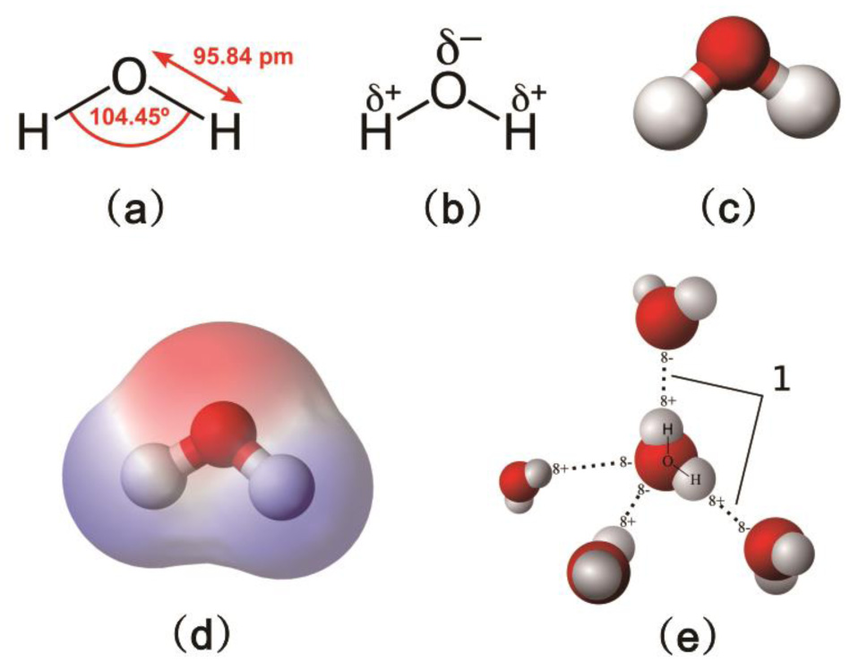)

In [ ]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    qed_vector = QED.properties(mol)
    '''Масса молекулы'''
    df.at[i, 'MW'] = round(qed_vector[0], 2)
    '''Строго говоря, это коэффициент, который показывает отношение концентрации вещества в октаноле
    к отношении концентрации вещества в воде. Оказалось, что играет огромную роль в фармакологии: чем выше
    значение logP, тем лучше вещество показывает себя в качестве лекарства '''
    df.at[i, 'AlogP'] = round(qed_vector[1], 2)
    df.at[i, 'MlogP'] = round(Crippen.MolLogP(mol), 2)
    '''Число атомов, оттягивающих на себя электронную плотность при образовании водородных связей (например, N, O)'''
    df.at[i, '#HBA'] = qed_vector[2]
    '''Число атомов и  групп, "отдающих" электронную плотность при образовании водородных связей'''
    df.at[i, '#HBD'] = qed_vector[3]
    '''Cумма площадей поверхности всех полярных атомов в молекуле. ОЧЕНЬ важный дескриптор в задачах медицинской химии:
       чем меньше значение TPSA, тем лучше молекула проходит через различные барьеры в нашем организме'''
    df.at[i, 'PSA'] = qed_vector[4]
    '''Число связей, которые могут свободно вращаться вокруг своей оси связи, не сталкиваясь со значительными пространственными препятствиями'''
    df.at[i, '#ROTB'] = qed_vector[5]

    df.at[i, 'MaxPartialCharge'] = round(Descriptors.MaxPartialCharge(mol), 2)
    df.at[i, 'MinPartialCharge'] = round(Descriptors.MinPartialCharge(mol), 2)

    df.at[i, '#AromaticCarbocycles'] = Lipinski.NumAromaticCarbocycles(mol)
    df.at[i, '#AromaticHeterocycles'] = Lipinski.NumAromaticHeterocycles(mol)
    '''Число атомов, отличных от углерода и водорода'''
    df.at[i, '#Heteroatoms'] = Lipinski.NumHeteroatoms(mol)

df.head()

,SMILES,MW,AlogP,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms
0,CC1=C(CCN2CCC(C3=NOC4=CC(F)=CC=C34)CC2)C(=O)N2...,426.49,3.08,3.08,6.0,1.0,84.39,4.0,0.26,-0.39,1.0,2.0,8.0
1,CC1=CC=CC2=C1OC1=CC=CC=C1C1(O)CCN(C)CC21,295.38,3.41,3.41,3.0,1.0,32.70,0.0,0.13,-0.46,2.0,0.0,3.0
2,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C21,236.27,3.39,3.39,1.0,1.0,46.33,0.0,0.32,-0.35,2.0,0.0,3.0
3,O=C1NC2=CC=CC=C2N1CCCN1CCC(N2C(=O)NC3=CC(Cl)=C...,425.92,3.35,3.35,3.0,2.0,78.82,5.0,0.33,-0.31,2.0,2.0,8.0
4,CN1CCN2C3=CC=CC=C3CC3=CC=CC=C3C2C1,264.37,3.08,3.08,2.0,0.0,6.48,0.0,0.07,-0.36,2.0,0.0,2.0


 ### **▶ Графовые дескрипторы** (основаны на представлении молекул в виде графов)







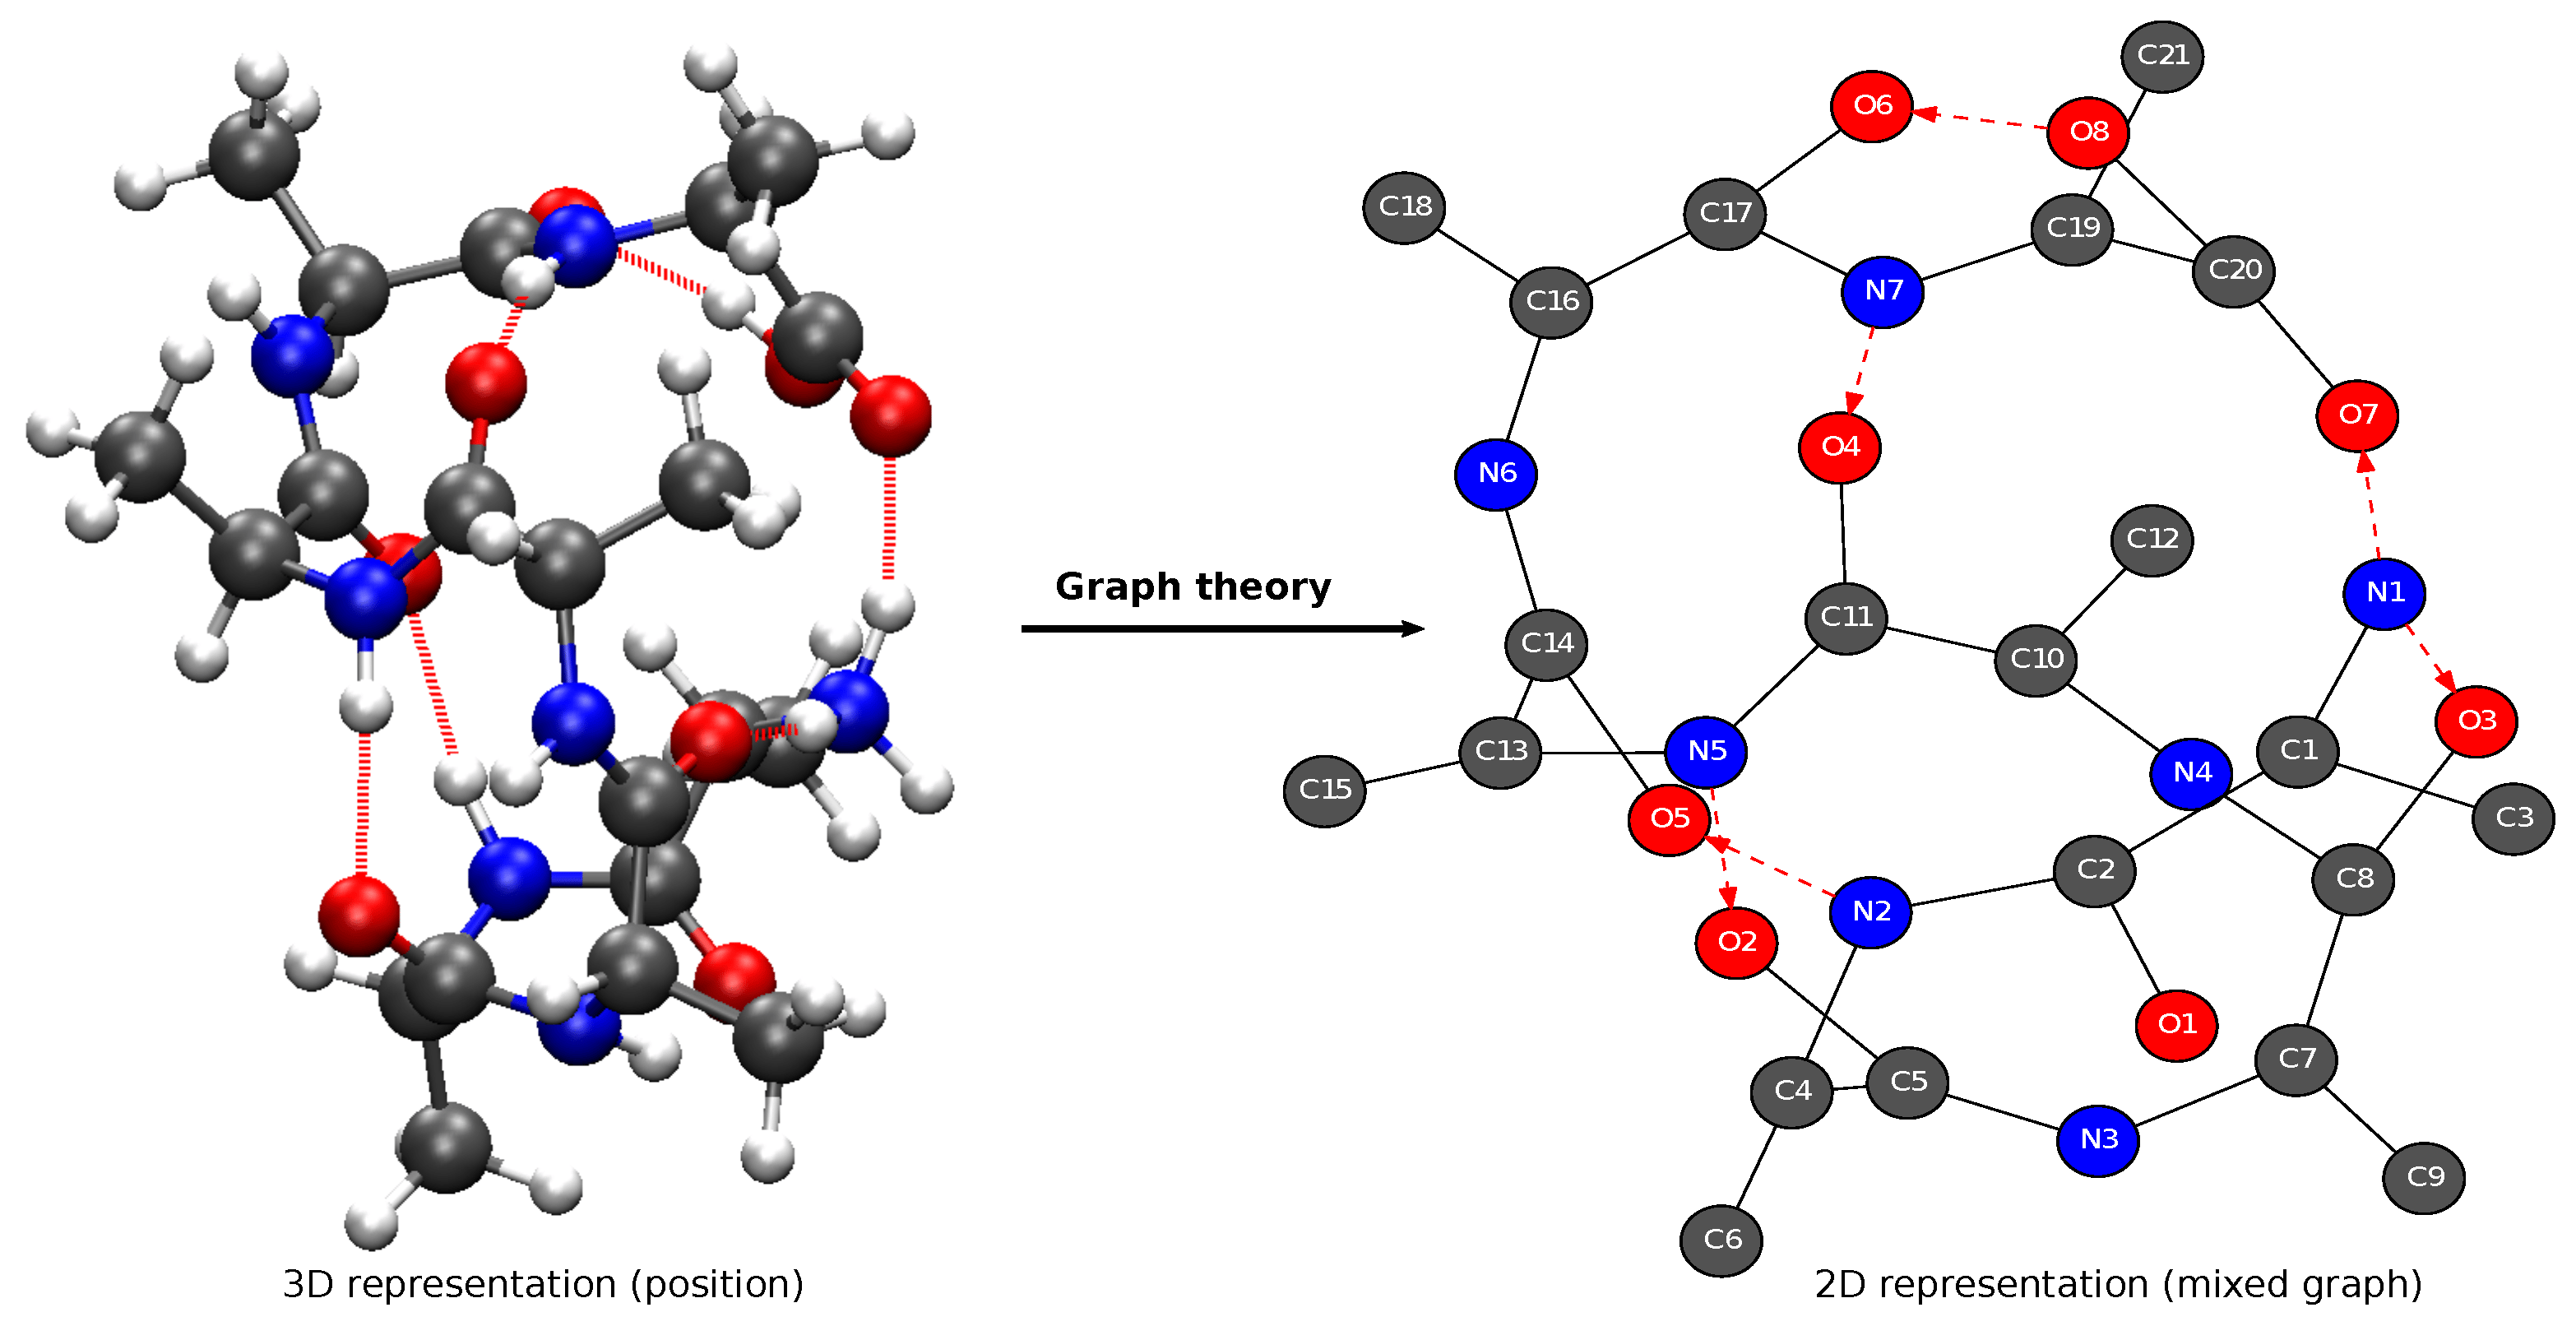

*Граф и его матрица смежности*

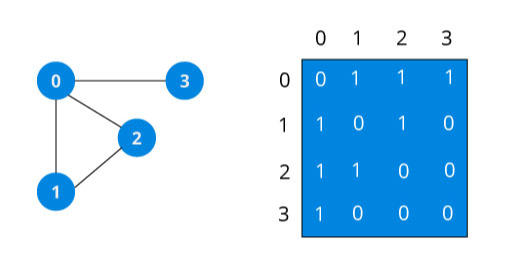

In [ ]:
for i, row in df.iterrows():
    mol = Chem.MolFromSmiles(row.SMILES)
    df.at[i, 'BalabanJ'] = round(GraphDescriptors.BalabanJ(mol), 2)
    df.at[i, 'BertzCT'] = round(GraphDescriptors.BertzCT(mol), 2)
    '''Среднее значение коэффициентов характеристического многочлена матрицы смежности молекулярного графа'''
    df.at[i, 'AvgIpc'] = round(GraphDescriptors.AvgIpc(mol), 2)
    df.at[i, 'Ipc'] = round(GraphDescriptors.Ipc(mol), 2)
    df.at[i, 'HallKierAlpha'] = round(GraphDescriptors.HallKierAlpha(mol), 2)
    df.at[i, 'Kappa1'] = round(GraphDescriptors.Kappa1(mol), 2)
    df.at[i, 'Kappa2'] = round(GraphDescriptors.Kappa2(mol), 2)
    df.at[i, 'Kappa3'] = round(GraphDescriptors.Kappa3(mol), 2)
df.head()

,SMILES,MW,AlogP,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,...,#AromaticHeterocycles,#Heteroatoms,BalabanJ,BertzCT,AvgIpc,Ipc,HallKierAlpha,Kappa1,Kappa2,Kappa3
0,CC1=C(CCN2CCC(C3=NOC4=CC(F)=CC=C34)CC2)C(=O)N2...,426.49,3.08,3.08,6.0,1.0,84.39,4.0,0.26,-0.39,...,2.0,8.0,1.24,1163.57,3.18,18087426.53,-2.58,20.33,8.16,3.78
1,CC1=CC=CC2=C1OC1=CC=CC=C1C1(O)CCN(C)CC21,295.38,3.41,3.41,3.0,1.0,32.70,0.0,0.13,-0.46,...,0.0,3.0,2.00,727.13,2.62,152461.48,-1.84,13.80,4.83,1.89
2,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C21,236.27,3.39,3.39,1.0,1.0,46.33,0.0,0.32,-0.35,...,0.0,3.0,2.31,596.95,2.55,20630.43,-2.55,10.59,4.04,1.57
3,O=C1NC2=CC=CC=C2N1CCCN1CCC(N2C(=O)NC3=CC(Cl)=C...,425.92,3.35,3.35,3.0,2.0,78.82,5.0,0.33,-0.31,...,2.0,8.0,1.21,1306.55,3.23,12343200.70,-2.77,19.21,7.81,3.48
4,CN1CCN2C3=CC=CC=C3CC3=CC=CC=C3C2C1,264.37,3.08,3.08,2.0,0.0,6.48,0.0,0.07,-0.36,...,0.0,2.0,1.90,634.82,2.61,76322.13,-1.80,11.98,4.64,1.83


❗Графовые дескрипторы обычно плохо интерпретируются с точки зрения химии

 ### **▶ Фингерпринты** (отображение функциональных групп, представленных в молекуле)











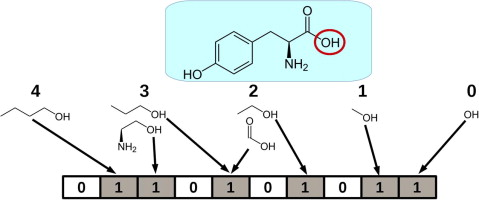

❗ **Фингерпринты** - двоичные строки или битовые векторы, где каждый бит или набор битов представляет наличие или отсутствие определенных подструктур или молекулярных особенностей в соединении



### **MACCS keys**

Основаны на фиксированном наборе из 166 химических подструктур , которые, как известно, имеют значение при поиске новых лекарственных средств и решении других химических задач. Можно использовать расширенный набор из 204 базовых структур, но это делают ОЧЕНЬ редко

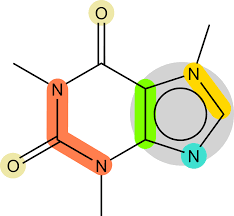

In [ ]:
from rdkit.Chem import MACCSkeys

In [ ]:
def generate_MACCS(data):
    MACCS_keys = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        maccs = list(MACCSkeys.GenMACCSKeys(mol).ToBitString())
        MACCS_keys.append(maccs)
    return np.array(MACCS_keys)

In [ ]:
MACCS_keys = generate_MACCS(df['SMILES'])

100%|██████████| 1190/1190 [00:02<00:00, 469.56it/s]


In [ ]:
for i, row in df.iterrows():
    for j in range(MACCS_keys.shape[1]):
        df.at[i, f'MAC_{j+1}'] =  MACCS_keys[i][j]

df.head()

,SMILES,MW,AlogP,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,...,MAC_158,MAC_159,MAC_160,MAC_161,MAC_162,MAC_163,MAC_164,MAC_165,MAC_166,MAC_167
0,CC1=C(CCN2CCC(C3=NOC4=CC(F)=CC=C34)CC2)C(=O)N2...,426.49,3.08,3.08,6.0,1.0,84.39,4.0,0.26,-0.39,...,1,1,1,1,1,1,1,1,1,0
1,CC1=CC=CC2=C1OC1=CC=CC=C1C1(O)CCN(C)CC21,295.38,3.41,3.41,3.0,1.0,32.70,0.0,0.13,-0.46,...,1,1,1,1,1,1,1,1,1,0
2,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C21,236.27,3.39,3.39,1.0,1.0,46.33,0.0,0.32,-0.35,...,0,1,0,0,1,1,1,1,1,0
3,O=C1NC2=CC=CC=C2N1CCCN1CCC(N2C(=O)NC3=CC(Cl)=C...,425.92,3.35,3.35,3.0,2.0,78.82,5.0,0.33,-0.31,...,0,1,1,0,1,1,1,1,1,0
4,CN1CCN2C3=CC=CC=C3CC3=CC=CC=C3C2C1,264.37,3.08,3.08,2.0,0.0,6.48,0.0,0.07,-0.36,...,0,1,0,1,1,1,1,0,1,0


### **Avalon fingerprints**

In [ ]:
from rdkit.Avalon import pyAvalonTools

In [ ]:
def generate_AVfpts(data):
    Avalon_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    '''Число бит можно регулировать. Обычно используется 512 или 1024'''
    for mol in tqdm(mols):
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
    return np.array(Avalon_fpts)

In [ ]:
Avalon_fpts = generate_AVfpts(df['SMILES'])

100%|██████████| 1190/1190 [00:00<00:00, 1244.72it/s]


In [ ]:
Avalon_fpts.shape

(1190, 512)

In [ ]:
for i, row in df.iterrows():
    for j in range(Avalon_fpts.shape[1]):
        df.at[i, f'A_{j+1}'] = Avalon_fpts[i][j]

df.head()

,SMILES,#HBA,#ROTB,#ALERTS,MlogP,#MR,#NHOH,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,...,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511,A_512
0,CC1=C(CCN2CCC(C3=NOC4=CC(F)=CC=C34)CC2)C(=O)N2...,6.0,4.0,0.0,3.08,113.51,1.0,1.0,2.0,8.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1,CC1=CC=CC2=C1OC1=CC=CC=C1C1(O)CCN(C)CC21,3.0,0.0,0.0,3.41,86.45,1.0,2.0,0.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C21,1.0,0.0,0.0,3.39,73.53,2.0,2.0,0.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,O=C1NC2=CC=CC=C2N1CCCN1CCC(N2C(=O)NC3=CC(Cl)=C...,3.0,5.0,0.0,3.35,119.46,2.0,2.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,CN1CCN2C3=CC=CC=C3CC3=CC=CC=C3C2C1,2.0,0.0,0.0,3.08,83.27,0.0,2.0,0.0,2.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### **ECFP6 fingerprints** (Extended Connectivity Fingerprint with diameter 6)

При выделении фрагментов учитывается не только ближайшее окружение атома, но и его соседи, находящиеся на расстоянии до 3-ех химических связей

In [ ]:
def generate_ECFP6(data):
    ECFP6_fpts = []
    mols = [Chem.MolFromSmiles(x) for x in data if x is not None]
    for mol in tqdm(mols):
        ecfp6 = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 3)
        ECFP6_fpts.append(ecfp6)
    return np.array(ECFP6_fpts)

In [ ]:
ECFP6_fpts = generate_ECFP6(df['SMILES'])

100%|██████████| 1190/1190 [00:00<00:00, 8811.39it/s]


In [ ]:
for i, row in df.iterrows():
    for j in range(ECFP6_fpts.shape[1]):
        df.at[i, f'ECFP6_{j+1}'] =  ECFP6_fpts[i][j]
df.head()

,SMILES,MW,AlogP,MlogP,#HBA,#HBD,PSA,#ROTB,MaxPartialCharge,MinPartialCharge,...,ECFP6_2039,ECFP6_2040,ECFP6_2041,ECFP6_2042,ECFP6_2043,ECFP6_2044,ECFP6_2045,ECFP6_2046,ECFP6_2047,ECFP6_2048
0,CC1=C(CCN2CCC(C3=NOC4=CC(F)=CC=C34)CC2)C(=O)N2...,426.49,3.08,3.08,6.0,1.0,84.39,4.0,0.26,-0.39,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CC1=CC=CC2=C1OC1=CC=CC=C1C1(O)CCN(C)CC21,295.38,3.41,3.41,3.0,1.0,32.70,0.0,0.13,-0.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C21,236.27,3.39,3.39,1.0,1.0,46.33,0.0,0.32,-0.35,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,O=C1NC2=CC=CC=C2N1CCCN1CCC(N2C(=O)NC3=CC(Cl)=C...,425.92,3.35,3.35,3.0,2.0,78.82,5.0,0.33,-0.31,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CN1CCN2C3=CC=CC=C3CC3=CC=CC=C3C2C1,264.37,3.08,3.08,2.0,0.0,6.48,0.0,0.07,-0.36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **PubChem**

Основаны на данных, хранящихся в базе PubChem. Содержат как количественные физико-химические дескрипторы, так и фингерпринты

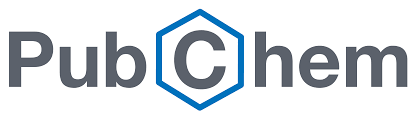

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=d7db052adaf923e574f05c659c9d0c94d853f0ace785114b580677a3904c1d66
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
from pubchempy import *

In [ ]:
def generate_pubchem(data):
    rows_to_del = []
    pubchem_features = []
    idx = 0
    for smi in tqdm(list(data)):
        try:
            cid = get_cids(smi, 'smiles')[0]
            if cid == 0:
                rows_to_del.append(idx)
            else:
                features_dict = Compound.from_cid(cid).to_dict()
                descriptors = [features_dict['atom_stereo_count'], features_dict['bond_stereo_count'],
                               features_dict['complexity'], features_dict['covalent_unit_count'],
                               features_dict['isotope_atom_count']
                              ]
                fingerprints = [int(fp) for fp in list(features_dict['cactvs_fingerprint'])]
                pubchem_features.append(descriptors + fingerprints)
        except:
            rows_to_del.append(idx)
        idx = idx + 1
    return np.array(pubchem_features), rows_to_del

In [ ]:
pubchem_features, rows_to_del = generate_pubchem(df['SMILES'])

100%|██████████| 1190/1190 [12:24<00:00,  1.60it/s]


In [ ]:
for i in rows_to_del:
    df = df.drop(labels=[i], axis=0)

In [ ]:
pubchem_features.shape

(1066, 886)

In [ ]:
number = 0
for i, row in df.iterrows():
    for j in range(pubchem_features.shape[1]):
        df.at[number, f'PUBCHEM_{j+1}'] = pubchem_features[number][j]
    number = number + 1
df.head()

,SMILES,#HBA,#ROTB,#ALERTS,MlogP,#MR,#NHOH,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
0,CC1=C(CCN2CCC(C3=NOC4=CC(F)=CC=C34)CC2)C(=O)N2...,6.0,4.0,0.0,3.08,113.51,1.0,1.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CC1=CC=CC2=C1OC1=CC=CC=C1C1(O)CCN(C)CC21,3.0,0.0,0.0,3.41,86.45,1.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NC(=O)N1C2=CC=CC=C2C=CC2=CC=CC=C21,1.0,0.0,0.0,3.39,73.53,2.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=C1NC2=CC=CC=C2N1CCCN1CCC(N2C(=O)NC3=CC(Cl)=C...,3.0,5.0,0.0,3.35,119.46,2.0,2.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CN1CCN2C3=CC=CC=C3CC3=CC=CC=C3C2C1,2.0,0.0,0.0,3.08,83.27,0.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.reset_index(drop=True, inplace=True) # обновим индексы строк


In [ ]:
df.info()

❗**Для каких-то молекул информации о дескрипторах из PubChem может не быть, и мы их удаляем. Также функция cid могла по ошибке выдать id другого компонента, и у нас появляются лишнее строки, где значения ранее  посчитанных дескрипторов и SMILES пропущены. Такие строки тоже удаляем**

In [ ]:
df.tail(215)

In [ ]:
df = df.head(958)
df.tail()

,SMILES,#HBA,#ROTB,#ALERTS,MlogP,#MR,#NHOH,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,...,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,PUBCHEM_882,PUBCHEM_883,PUBCHEM_884,PUBCHEM_885,PUBCHEM_886
953,N#CC1=CC=C2CN(CCC3CCC(NC(=O)C4=CC=NC5=CC=CC=C4...,4.0,5.0,0.0,4.84,129.71,1.0,2.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
954,C1=CC=C2CNCCC2=C1,1.0,0.0,0.0,1.33,41.85,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
955,C#CCN(C)[C@H](C)CC1=CC=CC=C1,1.0,4.0,1.0,2.18,61.07,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
956,COC1=C2O[C@H]3C(=O)C=C[C@H]4[C@H]5CC(C=C1)C2[C...,4.0,1.0,0.0,1.89,80.75,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
957,COC1=CC=C2NN=C(NC3CCN(CC4=CC=C5OCOC5=C4)CC3)C2=C1,6.0,5.0,0.0,3.38,107.13,2.0,2.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###❓**Нагенерировали кучу признаков. Как теперь их отобрать?**

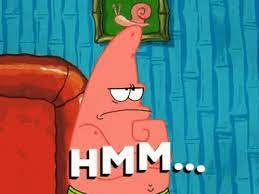

In [ ]:
import sklearn
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import StandardScaler

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ndf = df.drop('SMILES', axis=1)
ndf['logBB'] = sdf['logBB']
ndf.shape
#25%*528=132 50%=265 75=397
#25%*902=226 50%=451 75=677
#1414/2 707

(1190, 530)

In [ ]:
def select_features(X, y):
    fs = SelectKBest(score_func=mutual_info_regression, k=265)
    fs.fit(X, y)
    X_fs = fs.transform(X)
    return X_fs, fs

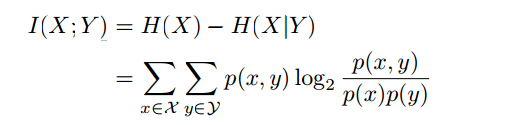

**❗*Критерий взаимной информации*: хорош тем, что улавливает любые виды зависимости (линейная, нелинейная и т.п.)**

Есть еще [F-classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif), [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) и другие

**❗❗Для задачи регрессии существует своя адаптация этих критериев: [f_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), [mutual_info_regression](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html)**


In [ ]:
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values

In [ ]:
X_fs, fs = select_features(X, y)

In [ ]:
cols_idxs = fs.get_support(indices=True) # получаем индексы тех столбцов, которые мы отобрали
ndf = ndf.iloc[:, cols_idxs]

In [ ]:
ndf.head()

,#HBA,#ROTB,#ALERTS,MlogP,#MR,#NHOH,#AromaticCarbocycles,#AromaticHeterocycles,#Heteroatoms,Morgan3,...,A_500,A_501,A_502,A_503,A_505,A_506,A_508,A_509,A_511,A_512
0,6.0,4.0,0.0,3.08,113.51,1.0,1.0,2.0,8.0,2.84,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,3.0,0.0,0.0,3.41,86.45,1.0,2.0,0.0,3.0,2.86,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,3.39,73.53,2.0,2.0,0.0,3.0,1.72,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,3.0,5.0,0.0,3.35,119.46,2.0,2.0,2.0,8.0,2.50,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2.0,0.0,0.0,3.08,83.27,0.0,2.0,0.0,2.0,2.55,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Columns: 132 entries, #HBA to A_512
dtypes: float64(132)
memory usage: 1.2 MB


# Linreg

In [ ]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
ndf['logBB'] = sdf['logBB']
split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "Q2": "r2", # коэффициент корреляции
         "MSE": make_scorer(mean_squared_error, squared=False) # иногда используют корень из MSE, т.к. его легче дифференцировать
         }
X = ndf.iloc[:, :-1].values # обучающие признаки
y = ndf.iloc[:, -1].values # целевая переменная

In [ ]:
from sklearn.linear_model import Lasso
lasso_model = Lasso()
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False) # определим RMSE как метрику оценки


In [ ]:
lasso_parameters = {
    'alpha': [0.05,0.1,0.00001],
     'fit_intercept': [True, False],
    'tol':[0.00001,0.001,0.0001],
}
#были убраны тип селекции и соответствующий рандом стейт, так как грид серч почему-то предпочитал выбирать рандом с очень большой толерантностью и значением альфа, что приводило к низким итоговым результатам.

In [ ]:
grid_search = GridSearchCV(estimator=lasso_model, param_grid=lasso_parameters, scoring=scorer, cv=5)
grid_search.fit(X, y) # выполним поиск по сетке
grid_search.best_params_

{'alpha': 0.1, 'fit_intercept': False, 'tol': 1e-05}

In [ ]:
lasso_model = Lasso(alpha=0.1, fit_intercept=False, tol=0.00001)
cv_scores = cross_validate(lasso_model, X, y, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean RMSE score is {cv_scores['test_MSE'].mean().round(3)} ± {cv_scores['test_MSE'].std().round(3)}")
print(f"Mean Q2 score is {cv_scores['test_Q2'].mean().round(3)} ± {cv_scores['test_Q2'].std().round(3)}")

On cross-validation:
Mean RMSE score is 0.632 ± 0.015
Mean Q2 score is 0.029 ± 0.029


In [ ]:
lasso_model.fit(X, y) # обучаем модель на всем датасете
y_pred = lasso_model.predict(X) # делаем предсказание
print(f"R2: {r2_score(y, y_pred).round(3)}") # вычисляем корреляцию

R2: 0.047


In [ ]:
#avalon25 {'alpha': 0.021,'fit_intercept': True,'tol': 0.08} RMSE 0.524 Q2 0.343 R2 0.395
#avalon50 {'alpha': 0.0012,'fit_intercept': False,'tol': 0.08} RMSE 0.516 Q2 0.363 R2 0.419
#avalon75 {'alpha': 0.0013,'fit_intercept': True,'tol': 0.01} RMSE 0.481 Q2 0.443 R2 0.715
#pubchem25 {'alpha': 0.0001,'fit_intercept': False,'tol': 0.009} RMSE 0.63 Q2 0.033 R2 0.052
#pubchem50 {'alpha': 0.05,'fit_intercept': False,'tol': 0.0001} RMSE 0.631 Q2 0.032 R2 0.053
#pubchem75 {'alpha': 0.05,'fit_intercept': False,'tol': 0.009} RMSE 0.627 Q2 0.043 R2 0.062
# avalon+pubchem {'alpha': 0.1,'fit_intercept': False,'tol': 0.00001} RMSE 0.632 Q2 0.029 R2 0.047



# Knn

In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [ ]:
split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "Q2": "r2",
         "MSE": make_scorer(mean_squared_error, squared=False)
         }

In [ ]:
ndf['logBB'] = sdf['logBB']
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = X, X, y, y

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = KNeighborsRegressor()

In [ ]:
parameters = {
    'n_neighbors': [3, 10, 7],
}

In [ ]:
rmse_mod = sklearn.metrics.make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [ ]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    # scoring='neg_mean_squared_error',
    scoring=rmse_mod,
    verbose=3)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ....................n_neighbors=3;, score=-0.452 total time=   0.0s
[CV 2/5] END ....................n_neighbors=3;, score=-0.555 total time=   0.0s
[CV 3/5] END ....................n_neighbors=3;, score=-0.598 total time=   0.0s
[CV 4/5] END ....................n_neighbors=3;, score=-0.537 total time=   0.0s
[CV 5/5] END ....................n_neighbors=3;, score=-0.632 total time=   0.0s
[CV 1/5] END ...................n_neighbors=10;, score=-0.446 total time=   0.0s
[CV 2/5] END ...................n_neighbors=10;, score=-0.550 total time=   0.0s
[CV 3/5] END ...................n_neighbors=10;, score=-0.626 total time=   0.0s
[CV 4/5] END ...................n_neighbors=10;, score=-0.574 total time=   0.0s
[CV 5/5] END ...................n_neighbors=10;, score=-0.585 total time=   0.0s
[CV 1/5] END ....................n_neighbors=7;, score=-0.441 total time=   0.0s
[CV 2/5] END ....................n_neighbors=7;, 

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 10, 7]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [ ]:
grid_search.best_params_

{'n_neighbors': 7}

In [ ]:
model = KNeighborsRegressor(n_neighbors=3)

In [ ]:
cv_scores = cross_validate(model, X_train, y_train, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean RMSE score is {cv_scores['test_MSE'].mean().round(3)} ± {cv_scores['test_MSE'].std().round(3)}")
print(f"Mean Q2 score is {cv_scores['test_Q2'].mean().round(3)} ± {cv_scores['test_Q2'].std().round(3)}")

On cross-validation:
Mean RMSE score is 0.498 ± 0.035
Mean Q2 score is 0.404 ± 0.079


In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.771


avalon25 3n RMSE 0.214 Q2 0.782 R2 0.91 New:0,494 0,415 0,766

avalon50 3n RMSE 0.222 Q2 0.767 R2 0.904 New: 0,485 0,437 0,779

avalon75 3n RMSE 0.225 Q2 0.759 R2 0.904 New:0,498 0,404 0,771

pubchem25 10n RMSE 0.647 Q2 -0.02 R2 0.185

pubchem50 10n RMSE 0.653 Q2 -0.038 R2 0.176

pubchem75 10n RMSE 0.65 Q2 -0.03 R2 0.175

avalon+pubchem 10n RMSE 0.648 Q2 -0.025 R2 0.187

# Tree

In [ ]:
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [ ]:
split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "Q2": "r2",
         "MSE": make_scorer(mean_squared_error, squared=False)
         }

In [ ]:
ndf['logBB'] = sdf['logBB']
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values
X_train, X_test, y_train, y_test = X, X, y, y

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = DecisionTreeRegressor()

In [ ]:
parameters = {
    'min_samples_leaf':[1,2,3],
    'random_state':[None,1,2],
}

In [ ]:
rmse_mod = sklearn.metrics.make_scorer(mean_squared_error, greater_is_better=False, squared=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    # scoring='neg_mean_squared_error',
    scoring=rmse_mod,
    verbose=3)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END min_samples_leaf=1, random_state=None;, score=-0.559 total time=   0.1s
[CV 2/5] END min_samples_leaf=1, random_state=None;, score=-0.769 total time=   0.1s
[CV 3/5] END min_samples_leaf=1, random_state=None;, score=-0.762 total time=   0.1s
[CV 4/5] END min_samples_leaf=1, random_state=None;, score=-0.730 total time=   0.1s
[CV 5/5] END min_samples_leaf=1, random_state=None;, score=-0.652 total time=   0.1s
[CV 1/5] END min_samples_leaf=1, random_state=1;, score=-0.571 total time=   0.1s
[CV 2/5] END min_samples_leaf=1, random_state=1;, score=-0.741 total time=   0.1s
[CV 3/5] END min_samples_leaf=1, random_state=1;, score=-0.796 total time=   0.1s
[CV 4/5] END min_samples_leaf=1, random_state=1;, score=-0.788 total time=   0.1s
[CV 5/5] END min_samples_leaf=1, random_state=1;, score=-0.626 total time=   0.1s
[CV 1/5] END min_samples_leaf=1, random_state=2;, score=-0.571 total time=   0.1s
[CV 2/5] END min_sample

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'random_state': [None, 1, 2]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [ ]:
grid_search.best_params_

{'min_samples_leaf': 2, 'random_state': 2}

In [ ]:
model = DecisionTreeRegressor(min_samples_leaf=2,random_state=2)

In [ ]:
cv_scores = cross_validate(model, X_train, y_train, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean RMSE score is {cv_scores['test_MSE'].mean().round(3)} ± {cv_scores['test_MSE'].std().round(3)}")
print(f"Mean Q2 score is {cv_scores['test_Q2'].mean().round(3)} ± {cv_scores['test_Q2'].std().round(3)}")

On cross-validation:
Mean RMSE score is 0.63 ± 0.025
Mean Q2 score is 0.033 ± 0.082


In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.975


In [ ]:
'''avalon25 msl=3 rmse 0.502 q2 0.396 r2 0.925
avalon50 msl=1 rmse 0.522 q2 0.345 r2 0.991
avalon75 msl=2 rmse 0.518 q2 0.359 r2 0.97
pubchem25 msl=3 rmse 0.823 q2 -0.653 r2 0.846
pubchem50 msl=3 rs=1 rmse 0.814 q2 -0.614 r2 0.844
pubchem75 msl=2 rmse 0.859 q2 -0.801 r2 0.938
avalon+pubchem msl=2 rs=2 rmse 0.63 q2 0.033 r2 0.975'''

# ensemble forest


In [ ]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [ ]:
split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "Q2": "r2",
         "MSE": make_scorer(mean_squared_error, squared=False)
         }

In [ ]:
ndf['logBB'] = sdf['logBB']
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values
X_train, X_test, y_train, y_test = X, X, y, y

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = RandomForestRegressor()

In [ ]:
parameters = {
    'n_estimators':[200,100],
    'min_samples_leaf':[1,2],
}

In [ ]:
rmse_mod = sklearn.metrics.make_scorer(mean_squared_error, greater_is_better=False, squared=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    # scoring='neg_mean_squared_error',
    scoring=rmse_mod,
    verbose=3)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END min_samples_leaf=1, n_estimators=200;, score=-0.447 total time=  11.2s
[CV 2/5] END min_samples_leaf=1, n_estimators=200;, score=-0.509 total time=  10.9s
[CV 3/5] END min_samples_leaf=1, n_estimators=200;, score=-0.544 total time=  10.5s
[CV 4/5] END min_samples_leaf=1, n_estimators=200;, score=-0.610 total time=  11.4s
[CV 5/5] END min_samples_leaf=1, n_estimators=200;, score=-0.358 total time=  10.7s
[CV 1/5] END min_samples_leaf=1, n_estimators=100;, score=-0.439 total time=   5.0s
[CV 2/5] END min_samples_leaf=1, n_estimators=100;, score=-0.514 total time=   6.1s
[CV 3/5] END min_samples_leaf=1, n_estimators=100;, score=-0.544 total time=   4.8s
[CV 4/5] END min_samples_leaf=1, n_estimators=100;, score=-0.618 total time=   5.8s
[CV 5/5] END min_samples_leaf=1, n_estimators=100;, score=-0.370 total time=   5.0s
[CV 1/5] END min_samples_leaf=2, n_estimators=200;, score=-0.441 total time=   8.7s
[CV 2/5] END min

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'min_samples_leaf': [1, 2],
                         'n_estimators': [200, 100]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [ ]:
grid_search.best_params_

{'min_samples_leaf': 2, 'n_estimators': 200}

In [ ]:
model = RandomForestRegressor(min_samples_leaf=2,n_estimators=200)

In [ ]:
cv_scores = cross_validate(model, X_train, y_train, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean RMSE score is {cv_scores['test_MSE'].mean().round(3)} ± {cv_scores['test_MSE'].std().round(3)}")
print(f"Mean Q2 score is {cv_scores['test_Q2'].mean().round(3)} ± {cv_scores['test_Q2'].std().round(3)}")

On cross-validation:
Mean RMSE score is 0.451 ± 0.019
Mean Q2 score is 0.504 ± 0.05


In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")

R2: 0.916


avalon25 default 0.39 0.636 0.945
avalon50 est=200 0.391 0.634 0.948
avalon75 est=300 0.388 0.639 0.948
pubchem25 est=200 0.622 0.055 0.871
pubchem50 est=200 sl=2 0.614 0.081 0.831
pubchem75 est=200 0.613 0.083 0.873
avalon+pubchem est=200 sl=2 0.451 0.504 0.916

# lgbm gradient

In [ ]:
import sklearn
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [ ]:
split = KFold(n_splits=5, random_state=41, shuffle=True)
scores= {
         "Q2": "r2",
         "MSE": make_scorer(mean_squared_error, squared=False)
         }

In [ ]:
ndf['logBB'] = sdf['logBB']
X = ndf.iloc[:, :-1].values
y = ndf.iloc[:, -1].values
X_train, X_test, y_train, y_test = X, X, y, y

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
model = LGBMRegressor()

In [ ]:
parameters = {
    'n_estimators':[200,100,300],
    'min_child_samples':[1,2],
}

In [ ]:
rmse_mod = sklearn.metrics.make_scorer(mean_squared_error, greater_is_better=False, squared=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    # scoring='neg_mean_squared_error',
    scoring=rmse_mod,
    verbose=3)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 265
[LightGBM] [Info] Start training from score -0.112426
[CV 1/5] END min_child_samples=1, n_estimators=200;, score=-0.308 total time=   0.4s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 265
[LightGBM] [Info] Start training from score -0.095956
[CV 2/5] END min_child_samples=1, n_estimat

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'min_child_samples': [1, 2],
                         'n_estimators': [200, 100, 300]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=3)

In [ ]:
grid_search.best_params_

{'min_child_samples': 2, 'n_estimators': 300}

In [ ]:
model = LGBMRegressor(min_child_samples=1,n_estimators=200)

In [ ]:

cv_scores = cross_validate(model, X_train, y_train, scoring=scores, cv=split)
print(f"On cross-validation:")
print(f"Mean RMSE score is {cv_scores['test_MSE'].mean().round(3)} ± {cv_scores['test_MSE'].std().round(3)}")
print(f"Mean Q2 score is {cv_scores['test_Q2'].mean().round(3)} ± {cv_scores['test_Q2'].std().round(3)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2155
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 265
[LightGBM] [Info] Start training from score -0.072605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 265
[LightGBM] [Info] Start training from score -0.070399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [ ]:
import matplotlib.pyplot as plt

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2206
[LightGBM] [Info] Number of data points in the train set: 1190, number of used features: 265
[LightGBM] [Info] Start training from score -0.079403
R2: 0.99


<function matplotlib.pyplot.show(close=None, block=None)>

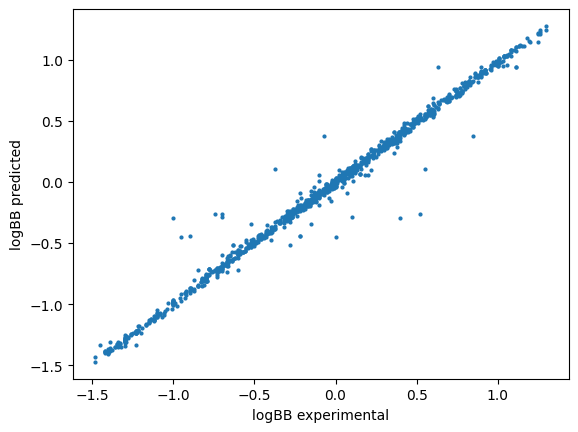

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R2: {r2_score(y_test, y_pred).round(3)}")
plt.xlabel('logBB experimental')
plt.ylabel('logBB predicted')
plt.scatter(y_test,y_pred,s=4)
plt.show

avalon25 est=200 mcs = 2 0.386 0.643 0.989
avalon50 est=200 mcs = 2 0.385 0.645 0.989
avalon75 est=300 mcs=1 0.381 0.652 0.99
pubchem25 est=100 mcs = 1 0.641 0.001 0.944
pubchem50 est=100 mcs =2 0.649 0.026 0.953
pubchem75 est=100 mcs = 1 0.655 0.046 0.957
avalon+pubchem est=100 mcs=2 0.647 0.02 0.967

# nn regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch modelues
import torch
from torch import nn
from torch.utils.data import DataLoader

# sklearn modelues
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score

In [ ]:
ndf['logBB'] = sdf['logBB']
X = ndf.iloc[:, :-1]
y = ndf.iloc[:, -1]
X_train, X_test, y_train, y_test = X, X, y, y
# split into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# print(f"{X_train.shape[0]} molecules in train, {X_test.shape[0]} molecules in test")

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# dataset class to supply data for NN
class logBBDataset(torch.utils.data.Dataset):

  def __init__(self, X, y):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.tensor(X, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [ ]:
# class trainer allows to train model and save learning history as well as best parameters
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler

        # learning history
        self.train_mse_losses = []
        self.valid_mse_losses = []

        self.train_r2_metrics = []
        self.valid_r2_metrics = []

        # save best [(MSE, R2) on train, (MSE, R2) on validation]
        self.best_metrics = [(0, 0), (0, 0)]

    def fit(self, epochs=None):
        if epochs is None: # if no new epocks are passed use value at initiation
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader) # train net

            # save metric and loss
            self.train_mse_losses.append(train_loss)
            self.train_r2_metrics.append(train_metric)

            # validate the net
            if self.validate:
              val_loss, val_metric = self._validate(self.validloader)
              self.valid_mse_losses.append(val_loss)
              self.valid_r2_metrics.append(val_metric)

              # in case we use sheduler update it
              if self.scheduler is not None:
                  self.scheduler.step(val_loss)
            else:
              val_loss = "NO"

            # check and update best metrics based on R2
            if (self.best_metrics[0][1] < train_metric) and (self.best_metrics[1][1] < val_metric):
              self.best_metrics = [(train_loss, train_metric), (val_loss, val_metric)]

            if self.verbose > 0:
              print()
              print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                        Train metric = {train_metric}, validation metric = {val_metric}")
              print()

        return self

    def _train(self, loader):
        self.model.train() # train state
        epoch_loss, n_samples = 0, 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device) # move data to device
            n = targets.shape[0]
            n_samples += n
            targets = targets.view(targets.shape[0],1) # reshape targets to match net output
            out = self.model(inputs) # get predictions
            loss = torch.sqrt(self.criterion(out, targets)) #calculate loss
            epoch_loss += loss.item() * n # accumulate loss
            self.optimizer.zero_grad()
            loss.backward() # back propagation

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step() # change weights

            # get predictions and target values from this epoch
            epoch_preds += list(out.detach().cpu().numpy())
            epoch_targets += list(targets.detach().cpu().numpy())

            self._clear_vram(inputs, targets, out) # clear RAM

        epoch_loss = epoch_loss/n_samples # calculate overall loss
        epoch_metric = self.metric(epoch_targets, epoch_preds) # get train metric
        if self.verbose > 1:
          print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval() # eval state
        epoch_loss, n_samples = 0, 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device) # move data to evice
                n = targets.shape[0]
                n_samples += n
                targets = targets.view(targets.shape[0],1) # reshape targets to match net output
                out = self.model(inputs) # get logits
                loss = torch.sqrt(self.criterion(out, targets)) # get loss

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item() * n # accumulate loss

                epoch_preds += list(out.detach().cpu().numpy())
                epoch_targets += list(targets.detach().cpu().numpy())

                self._clear_vram(inputs, targets, out) # clear RAM

        epoch_loss = epoch_loss/n_samples # get validation loss
        epoch_metric = self.metric(epoch_targets, epoch_preds) # get validation metric
        if self.verbose > 1:
          print("\n", end="")

        return epoch_loss, epoch_metric

    def _clear_vram(self, inputs, labels, outputs): # method to clear ram
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
class logBB_Net(nn.Module):
    def __init__(self, n_input_features, n_input_layer, n_inner_layer):
        super().__init__()

        self.regressor = nn.Sequential(
            nn.Linear(in_features=n_input_features, out_features=n_input_layer),
            #nn.Dropout(0.5),
            nn.LeakyReLU(),

            nn.Linear(in_features=n_input_layer, out_features=n_inner_layer),
            #nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(in_features=n_input_layer, out_features=n_inner_layer),
            #nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(in_features=n_input_layer, out_features=n_inner_layer),
            #nn.Dropout(0.5),
            nn.LeakyReLU(),

            nn.Linear(in_features=n_inner_layer, out_features=1)
        )

    def forward(self, x):
      return self.regressor(x)

In [ ]:
# initiate model
def initiate_model():
  logBB_net = logBB_Net(n_input_features=397, n_input_layer=350, n_inner_layer=350)

  # define some other parameters
  n_epochs = 100
  criterion = nn.MSELoss() # criterion for training
  optimizer = torch.optim.Adam(logBB_net.parameters(), lr=3e-4) # define optimizer with lr
  return logBB_net, n_epochs, criterion, optimizer





In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=41)

In [ ]:
q2_scores = []
rmse_scores = []

Best scores achieved:
On training set: Q2 0.98, RMSE 0.08
On test set: Q2 0.81, RMSE 0.27


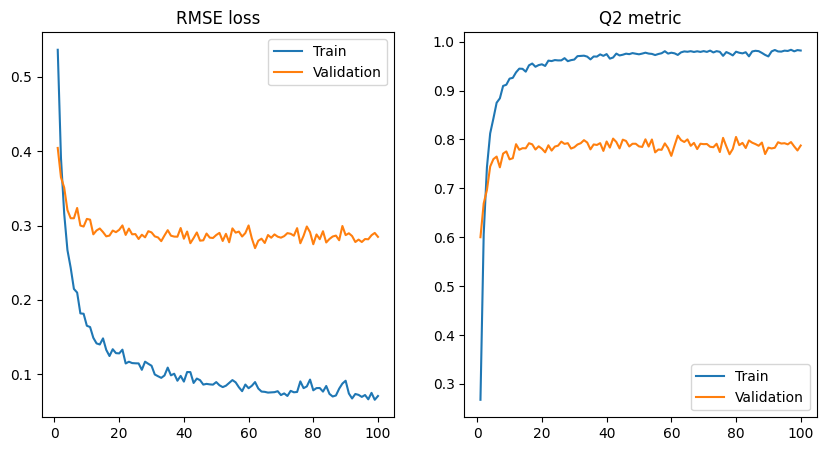

Best scores achieved:
On training set: Q2 0.99, RMSE 0.06
On test set: Q2 0.7, RMSE 0.32


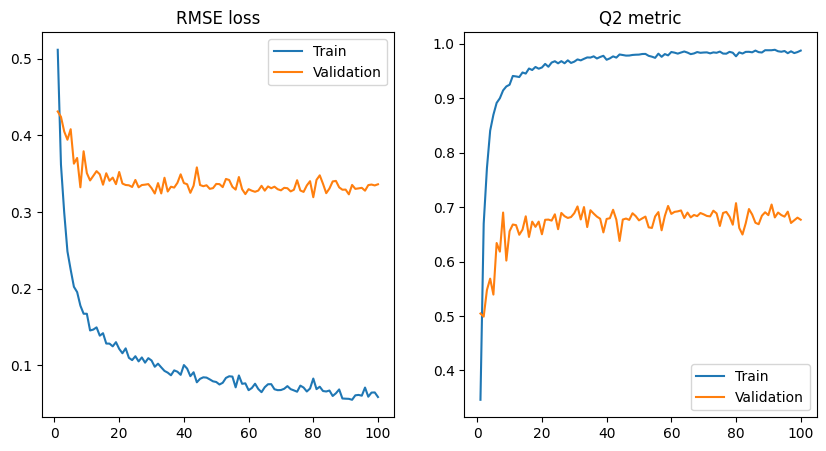

Best scores achieved:
On training set: Q2 0.99, RMSE 0.07
On test set: Q2 0.63, RMSE 0.37


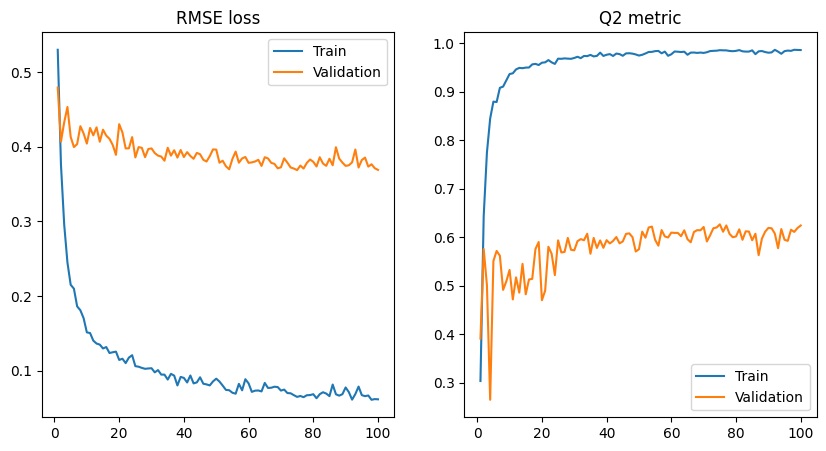

Best scores achieved:
On training set: Q2 0.96, RMSE 0.12
On test set: Q2 0.68, RMSE 0.37


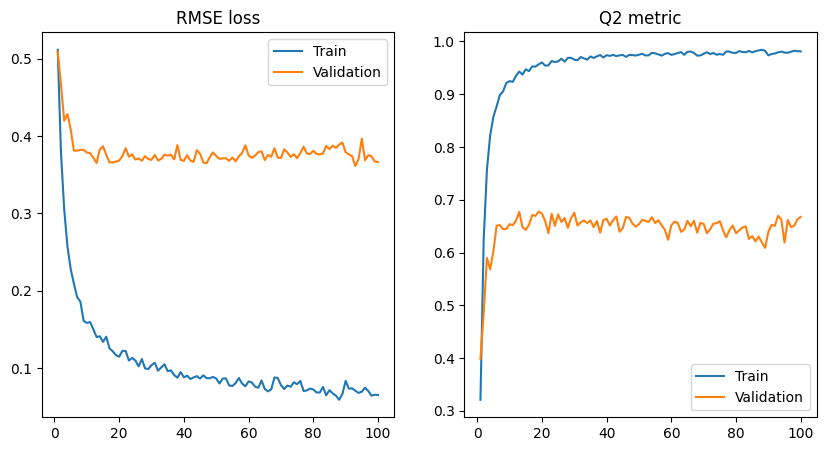

Best scores achieved:
On training set: Q2 0.98, RMSE 0.07
On test set: Q2 0.65, RMSE 0.33


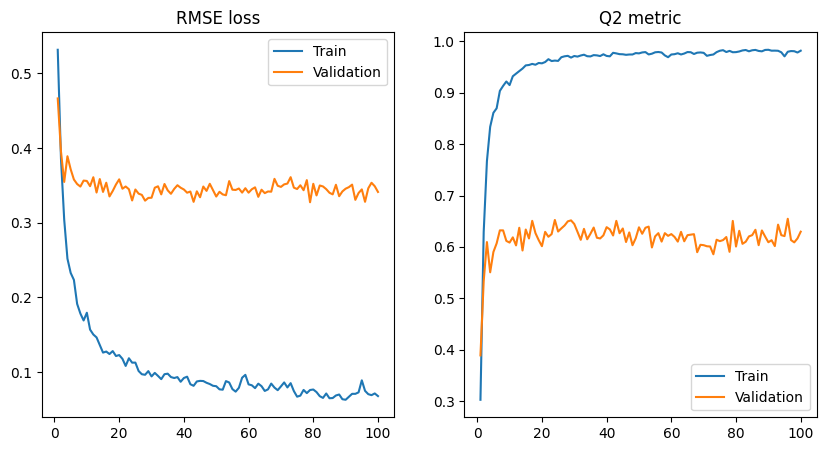

In [ ]:

for i, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    scaler = StandardScaler().fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    X_sc = scaler.transform(X)
    #print(y_train)
    # initiate datasets
    train_data = logBBDataset(X_train_sc, y_train.to_numpy())
    test_data = logBBDataset(X_test_sc, y_test.to_numpy())
    fin_data = logBBDataset(X_sc, y.to_numpy())

    trainloader = DataLoader(train_data, batch_size=10, shuffle=True)
    testloader = DataLoader(test_data, batch_size=10, shuffle=False)
    finloader = DataLoader(fin_data, batch_size=10, shuffle=False)

    logBB_net, n_epochs, criterion, optimizer = initiate_model()
    # initiate trainer
    trainer = Trainer(logBB_net, n_epochs, criterion,
                  optimizer, trainloader, testloader,
                  DEVICE, r2_score, verbose=0)

    # train model
    trainer.fit()

    print("Best scores achieved:")
    print(f"On training set: Q2 {round(trainer.best_metrics[0][1], 2)}, RMSE {round(trainer.best_metrics[0][0], 2)}")
    print(f"On test set: Q2 {round(trainer.best_metrics[1][1], 2)}, RMSE {round(trainer.best_metrics[1][0], 2)}")
    q2_scores.append(round(trainer.best_metrics[1][1], 2))
    rmse_scores.append(round(trainer.best_metrics[1][0], 2))


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()

    sns.lineplot(y=trainer.train_mse_losses, x=range(1, n_epochs + 1), label="Train", ax=axes[0])
    sns.lineplot(y=trainer.valid_mse_losses, x=range(1, n_epochs + 1), label="Validation", ax=axes[0])
    axes[0].set_title('RMSE loss')

    sns.lineplot(y=trainer.train_r2_metrics, x=range(1, n_epochs + 1), label="Train", ax=axes[1])
    sns.lineplot(y=trainer.valid_r2_metrics, x=range(1, n_epochs + 1), label="Validation", ax=axes[1])
    axes[1].set_title('Q2 metric')

    plt.show()



In [ ]:
np.mean(np.array(q2_scores))


0.6940000000000001

In [ ]:
np.std(np.array(q2_scores))


0.06280127387243034

In [ ]:
np.mean(np.array(rmse_scores))


0.332

In [ ]:
np.std(np.array(rmse_scores))

0.0370944739819828

# avalon25
350 без дропаутов лики рилу 0,619 0,369

450 хуже чем 350 0,618 0,372

250 хуже чем 350 0,617 0,371

300 хуже чем 350 0,616 0,371

320 хуже чем 350 0,564 0,394

370 хуже чем 350 0,568 0,396

дропауты 0,619 0,369

дропауты 0,5 0,606 0,378

хардсигмоид 0,548 0,409

elu 0,549 0,408

prelu 0.569 0.398

SELU 0.57 0.397

CELU 0.579 0.392

GELU 0.584 0.389

**avalon50**
0.652 0.35